In [1]:
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
reframed = series_to_supervised(values, 1, 1)
print("reframed")
#print(reframed)
#  normalize features - this will make it easier to interpret regression coefficnts
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

reframed
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [4]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 8) (8760,) (35039, 8) (35039,)


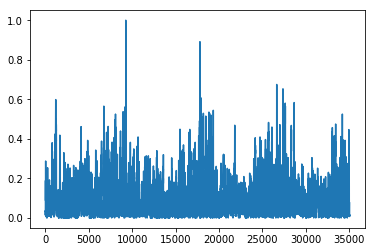

In [5]:
# plot the time series we are predicting
from pandas import Series
ts = Series(data=test_y) #index=pd.to_datetime(dates))
ts.plot()

In [6]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=0.001)
clf.fit(train_X, train_y) 
#note that this is coming very close to just using the most recent measurement
print(clf.coef_)
yhat = clf.predict(test_X)

[ 0.92011194  0.0199452  -0.02873412 -0.01381488  0.00926531 -0.00564339
 -0.01413331 -0.02505856]


In [7]:
#1 calculate RMSE
mse = mean_squared_error(test_y, yhat)
print('Test MSE: %.7f' % mse)
#Test MSE: 0.0006973

Test MSE: 0.0006973


In [8]:
# If you want error in the original usits, you'd need to transform the data back
# to calculate RMSE in original space
# one coulde invert scaling for forecast,but it's just a constant scaling.
#inv_yhat = scaler.inverse_transform(yhat)

In [9]:
# 2 what if we don't know the most recent polution level?
clf = Ridge(alpha=0.001)
clf.fit(train_X[:,1:], train_y) 
#note that this is coming close to just using the most recent measurement
print(clf.coef_)
yhat = clf.predict(test_X[:,1:])
#print(test_y.shape)
#print(yhat.shape)
mse = mean_squared_error(test_y, yhat)
print('Test MSE: %.7f' % mse)
# we get an order of magnitude higher error

[ 0.2893197  -0.39767969 -0.21497079  0.03484664 -0.09229506 -0.13636666
 -0.20739322]
Test MSE: 0.0073079


In [10]:
#3 naive forecast: future is the same as the most recent value 
#print(test_y)
# lag by 1 to get y_hat
#print('test_y mean, min, max:',ts.mean(), ts.min(), ts.max())
#print(ts.head())
#print(yhat.shape)
#print(test_y.shape)
yhat = ts.shift()
mse = mean_squared_error(test_y[1:], yhat[1:])
print('Test MSE: %.7f' % mse)
# the same as the original model

Test MSE: 0.0007139


In [11]:
### 5 AR(1)
ts = Series(data=train_y)
df = concat([ts.shift()], axis=1).dropna()  #create lags for a single series
clf = Ridge(alpha=0.001)
train_X = df.values
clf.fit(train_X,train_y[1:])
#print(train_y[2:].shape)
#print(train_X.shape)
ts_test = Series(data=test_y)
df_test = concat([ts_test.shift()], axis=1).dropna()  #create lags for a single series
test_X = df_test.values
#print(test_X.shape)
yhat = clf.predict(test_X)
print(clf.coef_)
mse = mean_squared_error(test_y[1:], yhat)
print('Test MSE: %.7f' % mse)

[0.94329808]
Test MSE: 0.0007011


In [12]:
### 5 generate more lags AR(3)
ts = Series(data=train_y)
df = concat([ts.shift(), ts.shift(2), ts.shift(3)], axis=1).dropna()  #create lags for a single series
clf = Ridge(alpha=0.001)
train_X = df.values
clf.fit(train_X,train_y[3:])
#print(train_y[2:].shape)
#print(train_X.shape)
ts_test = Series(data=test_y)
df_test = concat([ts_test.shift(), ts_test.shift(2), ts_test.shift(3)], axis=1).dropna()  #create lags for a single series
test_X = df_test.values
#print(test_X.shape)
yhat = clf.predict(test_X)
print(clf.coef_)
mse = mean_squared_error(test_y[3:], yhat)
print('Test MSE: %.7f' % mse)


[ 0.85807318  0.13636826 -0.04825153]
Test MSE: 0.0007144


In [13]:
ts = Series(data=train_y)
df = concat([ts.shift(), ts.shift(2), ts.shift(3), ts.shift(4), ts.shift(5)], axis=1).dropna()  #create lags for a single series
clf = Ridge(alpha=0.001)
train_X = df.values
clf.fit(train_X,train_y[5:])
#print(train_y[2:].shape)
#print(train_X.shape)
ts_test = Series(data=test_y)
df_test = concat([ts_test.shift(), ts_test.shift(2), ts_test.shift(3), ts_test.shift(4), ts_test.shift(5)], axis=1).dropna()
test_X = df_test.values
#print(test_X.shape)
yhat = clf.predict(test_X)
print(clf.coef_)
mse = mean_squared_error(test_y[5:], yhat)
print('Test MSE: %.7f' % mse)


[ 0.85691947  0.14046588 -0.02578443 -0.03350998  0.0070721 ]
Test MSE: 0.0007150


### Now do the same for temperature

In [14]:
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
reframed = series_to_supervised(values, 1, 1)
#  normalize features - this will make it easier to interpret regression coefficnts
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)  
1   0.000000        0.0  0.148893  0.367647  0.245902  
2   0.000000        0.0  0.159960  0.426471  0.229508  
3   0.000000        0.0  0.182093  0.485294  0.229508  
4   0.037037        0.0  0.138833  0.485294  0.229508  
5   0.074074        0.0  0.109658  0.485294  0.213115  


In [15]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 10) (8760,) (35039, 10) (35039,)


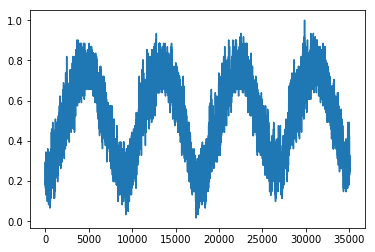

In [16]:
from pandas import Series
ts = Series(data=test_y)
ts.plot()

In [17]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=0.001)
clf.fit(train_X, train_y) 
#note that this is coming very close to just using the most recent measurement
print(clf.coef_)
yhat = clf.predict(test_X)

[ 1.79157491e-02  3.11041202e-01  9.70462860e-01 -5.85280087e-04
 -3.39363468e-03 -1.14997577e-02 -1.01520120e-02 -1.85823654e-02
 -2.79198695e-02 -2.84501237e-01]


In [18]:
mse = mean_squared_error(test_y, yhat)
print('Test MSE: %.7f' % mse)

Test MSE: 0.0005666


In [19]:
clf = Ridge(alpha=0.001)
clf.fit(train_X[:,3:], train_y) 
#note that this is coming close to just using the most recent measurement
print(clf.coef_)
yhat = clf.predict(test_X[:,3:])
#print(test_y.shape)
#print(yhat.shape)
mse = mean_squared_error(test_y, yhat)
print('Test MSE: %.7f' % mse)


[-0.37915272  0.00261372  0.05957149 -0.31899784 -0.26660537 -0.46664911
  0.66714229]
Test MSE: 0.0087877


In [20]:
#AR(1) 
ts = Series(data=train_y)
df = concat([ts.shift()], axis=1).dropna()  #create lags for a single series
clf = Ridge(alpha=0.001)
train_X = df.values
clf.fit(train_X,train_y[1:])
#print(train_y[2:].shape)
#print(train_X.shape)
ts_test = Series(data=test_y)
df_test = concat([ts_test.shift()], axis=1).dropna()  #create lags for a single series
test_X = df_test.values
#print(test_X.shape)
yhat = clf.predict(test_X)
print(clf.coef_)
mse = mean_squared_error(test_y[1:], yhat)
print('Test MSE: %.7f' % mse)

[0.99376307]
Test MSE: 0.0006148


In [21]:
ts = Series(data=train_y)
df = concat([ts.shift(), ts.shift(2), ts.shift(3)], axis=1).dropna()  #create lags for a single series
clf = Ridge(alpha=0.001)
train_X = df.values
clf.fit(train_X,train_y[3:])
#print(train_y[2:].shape)
#print(train_X.shape)
ts_test = Series(data=test_y)
df_test = concat([ts_test.shift(), ts_test.shift(2), ts_test.shift(3)], axis=1).dropna()  #create lags for a single series
test_X = df_test.values
#print(test_X.shape)
yhat = clf.predict(test_X)
print(clf.coef_)
mse = mean_squared_error(test_y[3:], yhat)
print('Test MSE: %.7f' % mse)

[ 1.24449433 -0.00235707 -0.25265607]
Test MSE: 0.0005134


In [22]:
# AR(5) model
ts = Series(data=train_y)
df = concat([ts.shift(), ts.shift(2), ts.shift(3), ts.shift(4), ts.shift(5)], axis=1).dropna()  #create lags for a single series
clf = Ridge(alpha=0.001)
train_X = df.values
clf.fit(train_X,train_y[5:])
#print(train_y[2:].shape)
#print(train_X.shape)
ts_test = Series(data=test_y)
df_test = concat([ts_test.shift(), ts_test.shift(2), ts_test.shift(3), ts_test.shift(4), ts_test.shift(5)], axis=1).dropna()
test_X = df_test.values
#print(test_X.shape)
yhat = clf.predict(test_X)
print(clf.coef_)
mse = mean_squared_error(test_y[5:], yhat)
print('Test MSE: %.7f' % mse)


[ 1.22713337  0.00194111 -0.15573717 -0.11357566  0.02922186]
Test MSE: 0.0005101


In [23]:
test_y

array([0.1967213 , 0.1967213 , 0.18032786, ..., 0.26229507, 0.24590163,
       0.26229507], dtype=float32)